# Confidence Progress

In [134]:
%run ../Modules/Importing.py

In [135]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [136]:
filename = '6845-56745-290'
filepath1 = '/Users/ballanr/Desktop/File Outputs/Wave and Flux/'+filename+'.csv'

openfile = pd.read_csv(filepath1)

wave = openfile['Wavelength']
flux = openfile['Flux']

In [137]:
center = f.find_nearest(wave,16811.17934)

L1 = center - 240 -60# ~ 56 Angstroms
L2 = center - 151 # ~ 35 Angstroms
R1 = center + 150
R2 = center + 241 + 60

linemean = np.mean(flux[L2:R1])
leftwindow = np.mean(flux[L1:L2])
rightwindow = np.mean(flux[R1:R2])
cmean = (0.5)*(leftwindow + rightwindow)

abovex = []
abovey = []
belowx = []
belowy = []

R1-L2

301

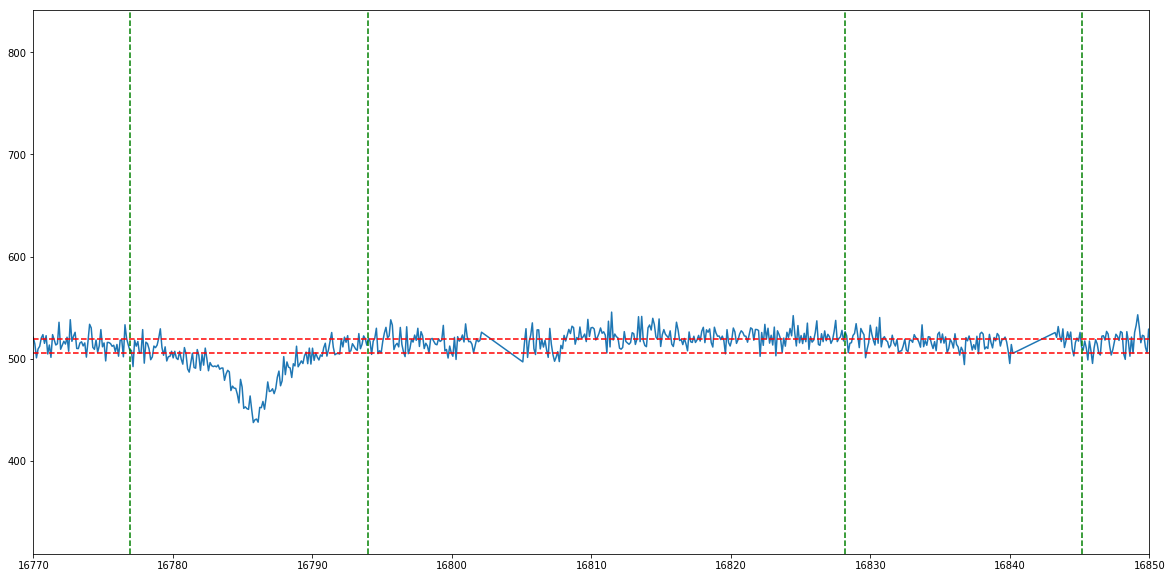

In [143]:
plt.figure(figsize=(20,10))
#plt.scatter(wave,flux,color='black',s=25);
plt.plot(wave,flux);
plt.axhline(linemean,ls='dashed',color='red')
plt.axhline(cmean,ls='dashed',color='red')
plt.axvline(wave[L1],ls='dashed',color='green')
plt.axvline(wave[L2],ls='dashed',color='green')
plt.axvline(wave[R1],ls='dashed',color='green')
plt.axvline(wave[R2],ls='dashed',color='green')
#plt.ylim(100,200);
plt.xlim(16770,16850);

In [139]:
for k in range(R1-L2):
    x = wave[L2 + k]
    y = flux[L2 + k]
    gy = y - cmean
    
    if gy > 0:
        abovex.append(x)
        abovey.append(y)
    else:
        belowx.append(x)
        belowy.append(y)

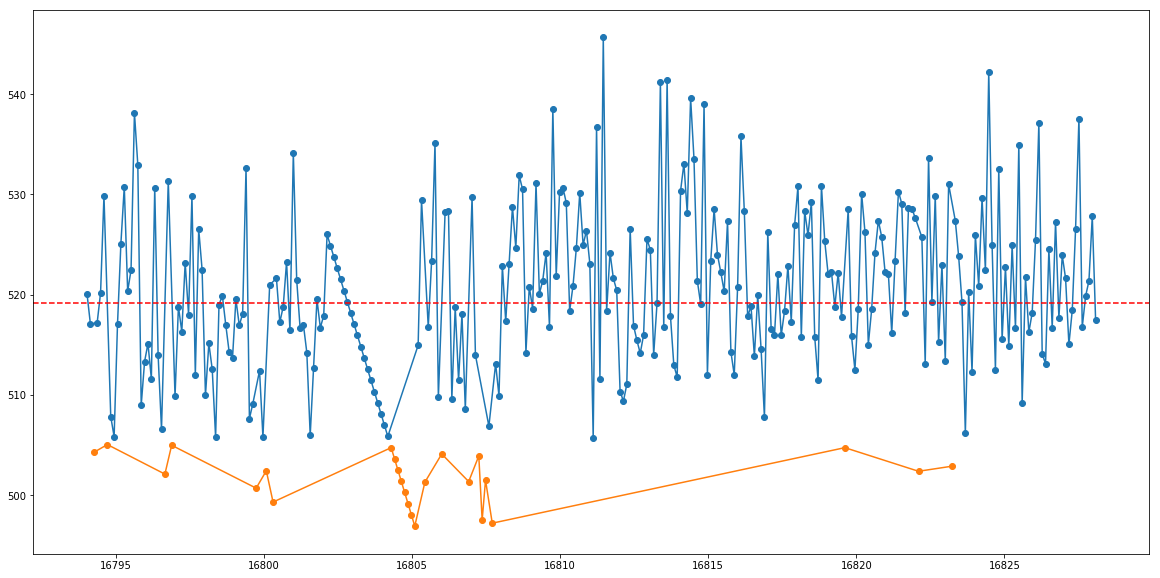

In [140]:
plt.figure(figsize=(20,10));
plt.plot(abovex,abovey);
plt.scatter(abovex,abovey);
plt.plot(belowx,belowy);
plt.scatter(belowx,belowy);
plt.axhline(linemean,ls='dashed',color='red');

In [141]:
len(abovex),len(abovey),len(belowx),len(belowy)

(276, 276, 25, 25)

In [142]:
aboveArea = 0
belowArea = 0

for i in range(len(abovex)-1):

            trapezoid = (0.5)*(abovex[i+1] - abovex[i])*(abovey[i+1] + abovey[i] - (2*cmean))
            aboveArea += trapezoid

for j in range(len(belowx)-1):

            trapezoid1 = (0.5)*(belowx[j+1] - belowx[j])*(-belowy[j+1] - belowy[j] + (2*cmean))
            belowArea += trapezoid1

if belowArea != 0:
    funratio = (aboveArea / belowArea)
else: 
    funratio = aboveArea
funratio,aboveArea,belowArea

(4.611440448933342, 498.2352943416164, 108.04331094785398)

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [147]:
histos = pd.read_csv('/Users/ballanr/Desktop/peakstocompare.csv')
histos1 = pd.read_csv('/Users/ballanr/Desktop/testtest2.csv')
histos2 = pd.read_csv('/Users/ballanr/Desktop/testtest3.csv')

In [180]:
kevins_confidence = histos['Confidence1'][7:]
ebbets = histos['Confidence2'][7:]
mean = histos['Confidence 3'][7:]
Area = histos['Area Ratios'][7:]
EqW = histos['Br 11 EqW'][7:]

kevins_confidence1 = histos1['Confidence1'][7:]
ebbets1 = histos1['Confidence2'][7:]
mean1 = histos1['Confidence 3'][7:]
Area1 = histos1['Area Ratios'][7:]
EqW1 = histos1['Br 11 EqW'][7:]

kevins_confidence2 = histos2['Confidence1'][19:]
kevins_confidence21 = histos2['Confidence1'][:19]
ebbets2 = histos2['Confidence2'][19:]
ebbets21 = histos2['Confidence2'][:19]
mean2 = histos2['Confidence 3'][19:]
mean21 = histos2['Confidence 3'][:19]
Area2 = histos2['Area Ratios'][19:]
Area21 = histos2['Area Ratios'][:19]
EqW2 = histos2['Br 11 EqW'][16:]

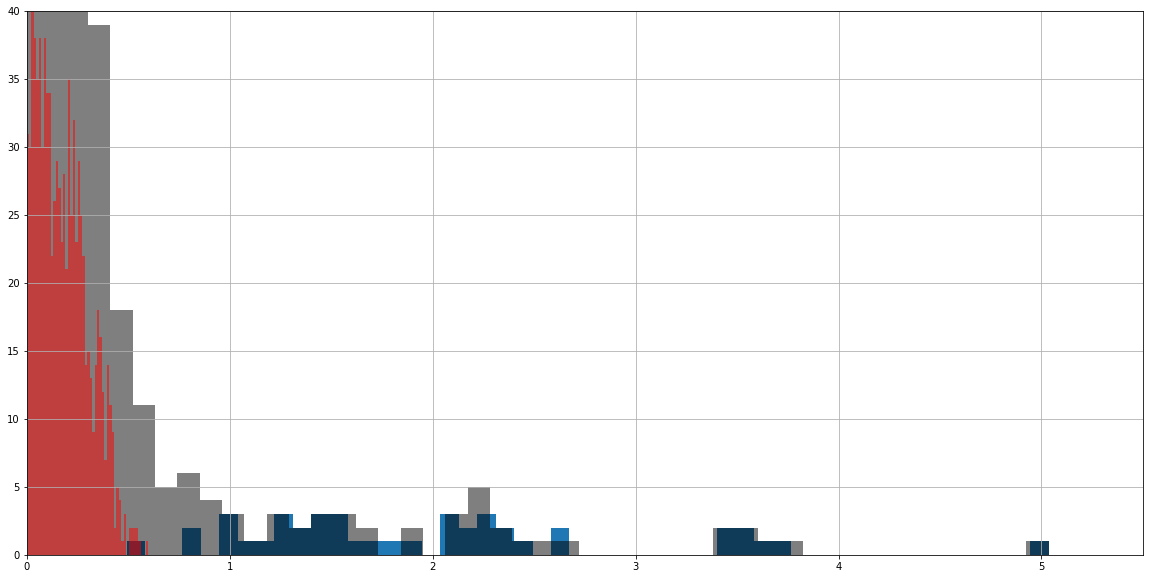

In [208]:
plt.figure(figsize=(20,10));
kevins_confidence.hist(bins=50);
kevins_confidence1.hist(bins=50,color='black',alpha=0.5);
kevins_confidence2.hist(bins=50,color='red',alpha=0.5);
plt.xlim(0,5.5);
plt.ylim(0,40);

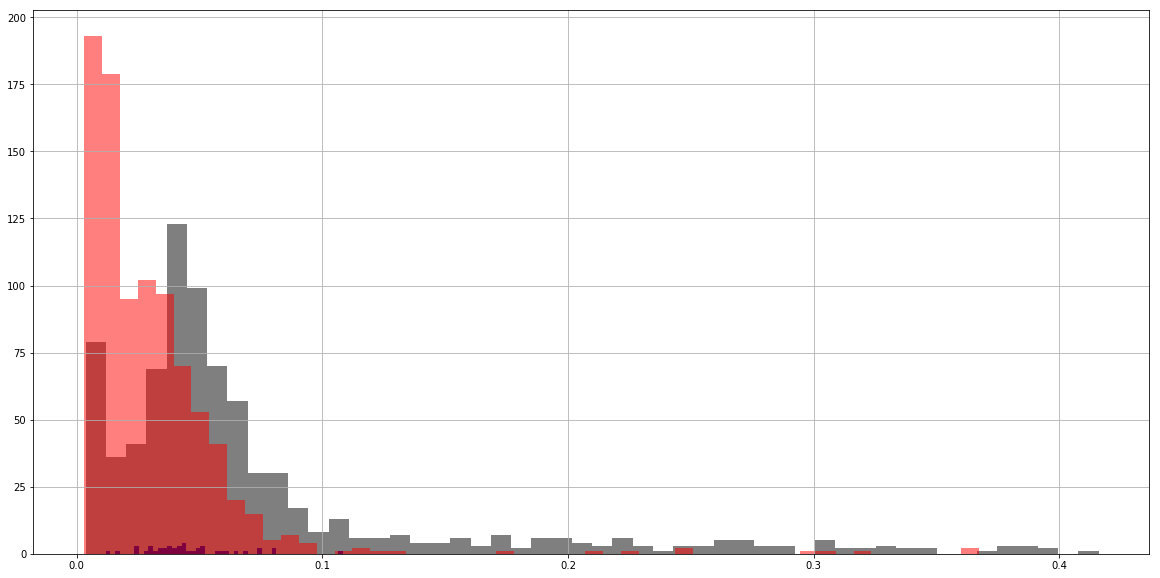

In [162]:
plt.figure(figsize=(20,10));
ebbets.hist(bins=50,color='blue');
ebbets1.hist(bins=50,color='black',alpha=0.5);
ebbets2.hist(bins=50,color='red',alpha=0.5);
#plt.xlim(0,0.01);
#plt.ylim(0,5);

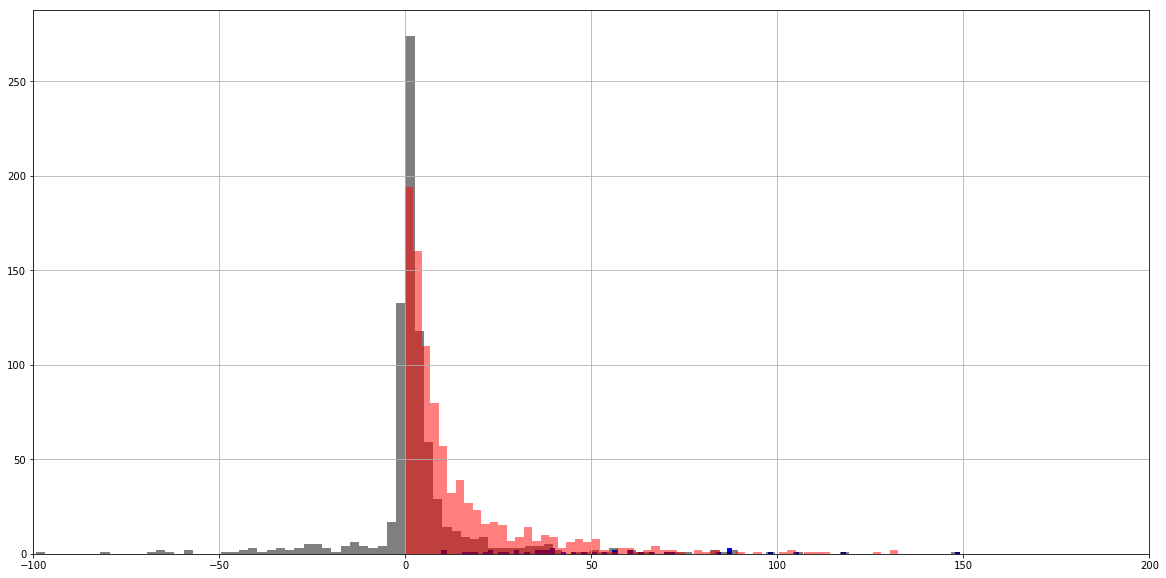

In [168]:
plt.figure(figsize=(20,10));
mean.hist(bins=100,color='blue');
mean1.hist(bins=100,color='black',alpha=0.5);
mean2.hist(bins=500,color='red',alpha=0.5);
plt.xlim(-100,200);
#plt.ylim(0,20)

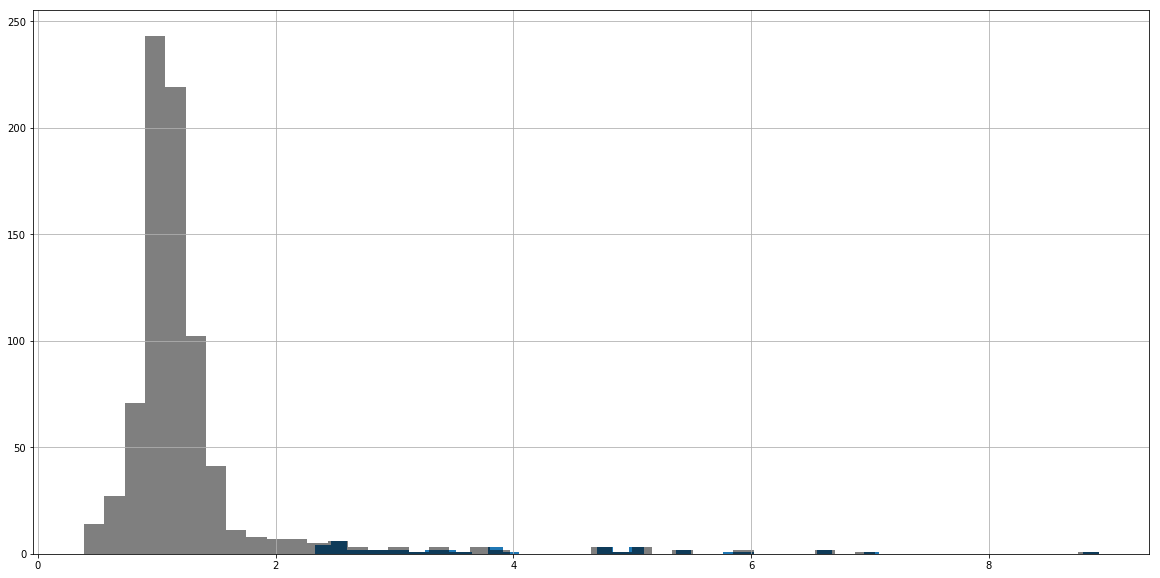

In [172]:
plt.figure(figsize=(20,10));
Area.hist(bins=50);
Area1.hist(bins=50,color='black',alpha=0.5);
#plt.xlim(2,3);
#plt.ylim(0,5);

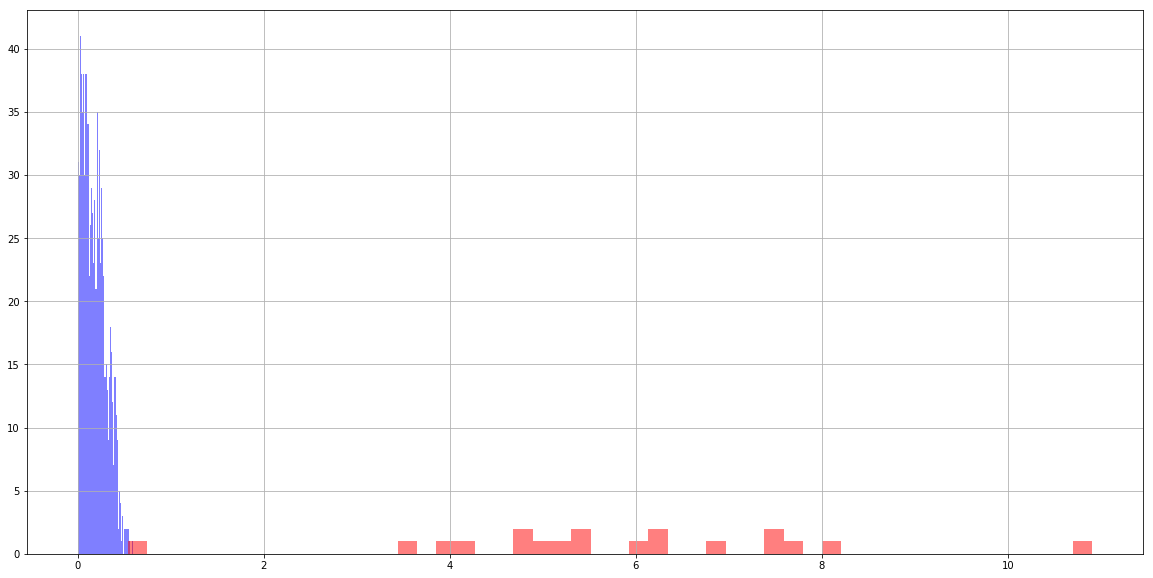

In [184]:
plt.figure(figsize=(20,10));
kevins_confidence2.hist(bins=50,color='blue',alpha=0.5);
kevins_confidence21.hist(bins=50,color='red',alpha=0.5);

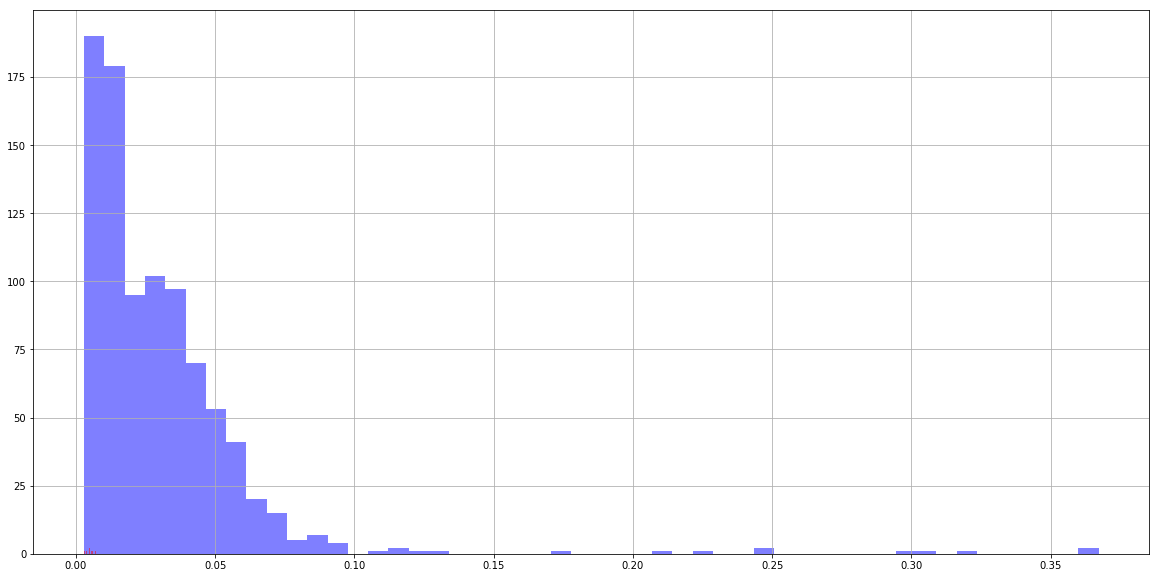

In [187]:
plt.figure(figsize=(20,10));
ebbets2.hist(bins=50,color='blue',alpha=0.5);
ebbets21.hist(bins=50,color='red',alpha=0.5);

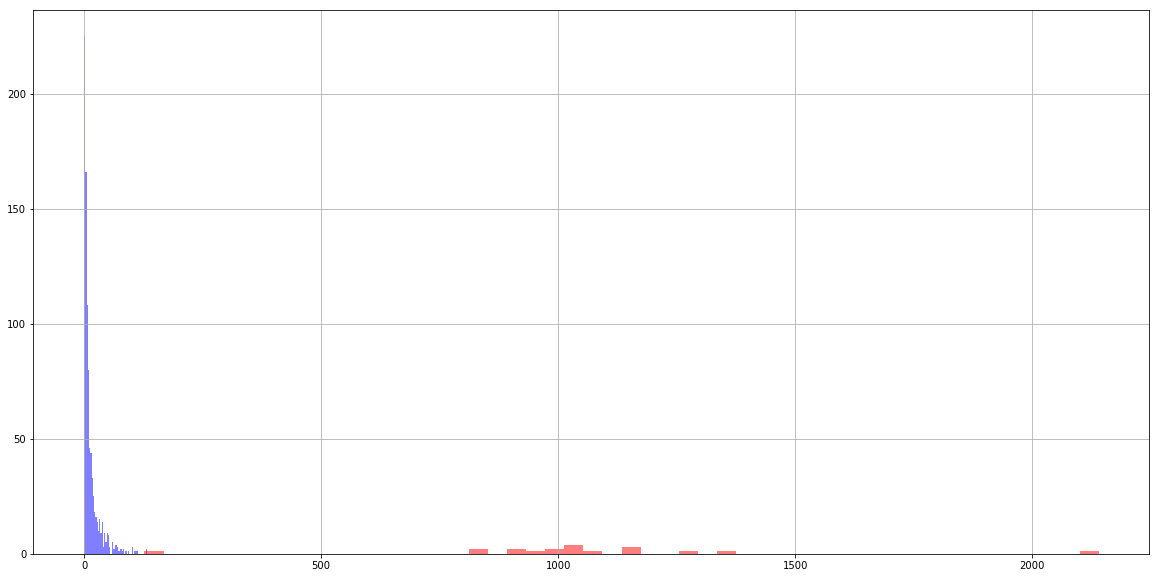

In [188]:
plt.figure(figsize=(20,10));
mean2.hist(bins=50,color='blue',alpha=0.5);
mean21.hist(bins=50,color='red',alpha=0.5);

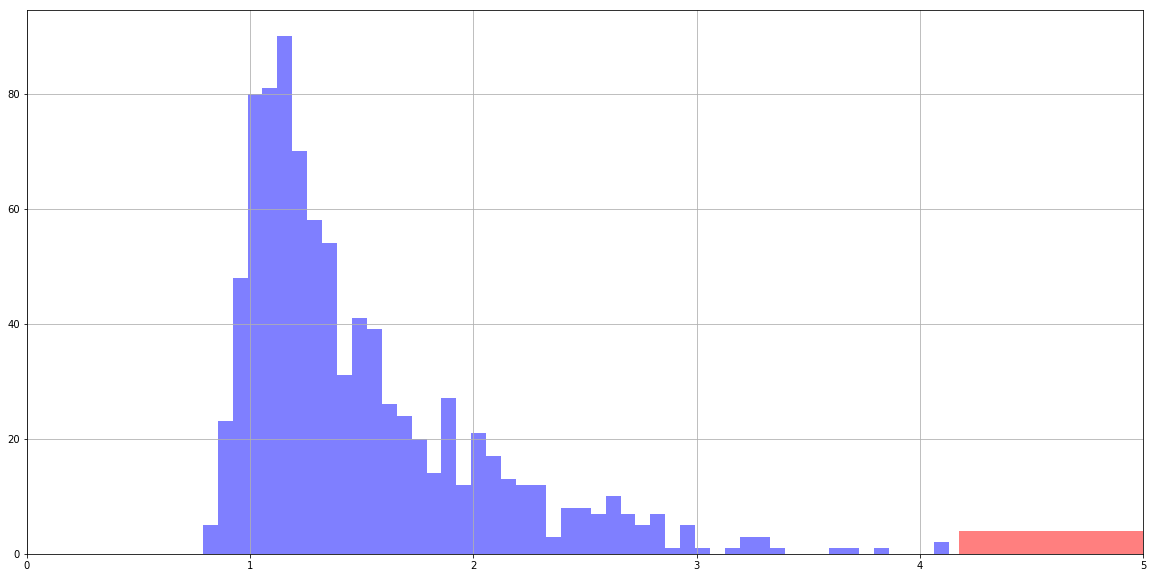

In [190]:
plt.figure(figsize=(20,10));
Area2.hist(bins=50,color='blue',alpha=0.5);
Area21.hist(bins=50,color='red',alpha=0.5);
plt.xlim(0,5);

In [191]:
from scipy.stats import norm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

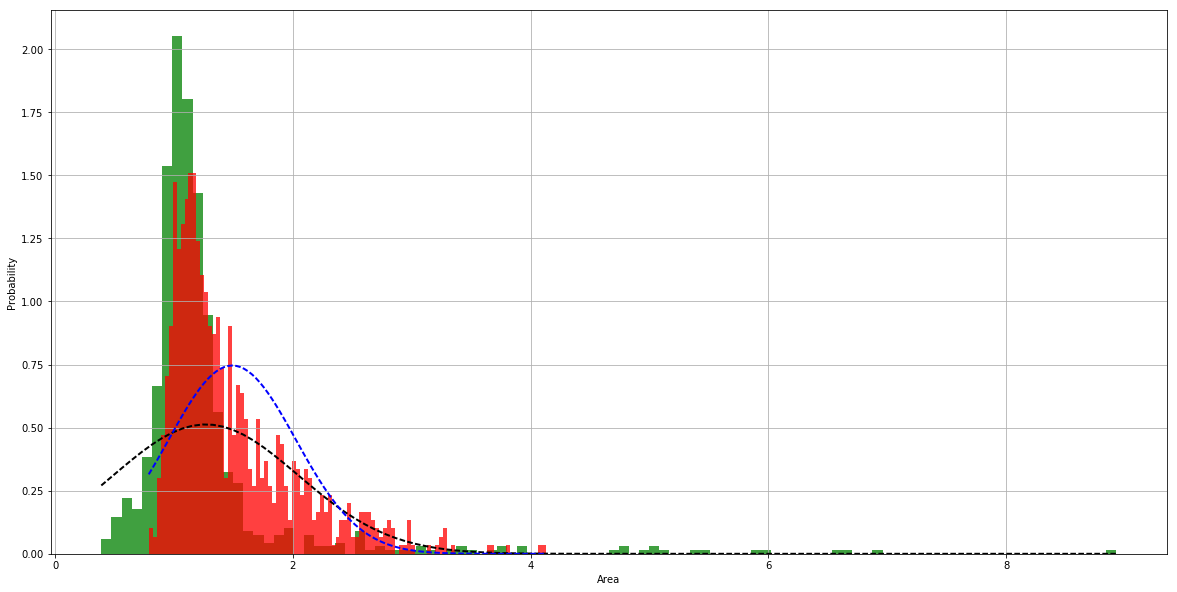

In [204]:
plt.figure(figsize=(20,10))
# best fit of data
(mu, sigma) = norm.fit(Area1)
(mu1, sigma1) = norm.fit(Area2)

# the histogram of the data
n, bins, patches = plt.hist(Area1, 100, normed=1, facecolor='green', alpha=0.75)
n1, bins1, patches1 = plt.hist(Area2, 100, normed=1, facecolor='red', alpha=0.75)

# add a 'best fit' line
y = mlab.normpdf( bins, mu, sigma)
l = plt.plot(bins, y, '--',color='black',linewidth=2)
y1 = mlab.normpdf( bins1, mu1, sigma1)
l1 = plt.plot(bins1, y1, 'b--', linewidth=2)
#plot

plt.xlabel('Area')
plt.ylabel('Probability')
plt.grid(True)

plt.show()